# Experiment: 2 **Food Vision**

## Checking GPU

In [ ]:
!nvidia-smi

## Helper Function

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## TensorFlow Datasets

### Downloading the datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
tf.version.VERSION

'2.7.0'

In [ ]:
# List all avaible datasets
datasets_list = tfds.list_builders()
len(datasets_list)
print("food101" in datasets_list)

True


In [ ]:
# Loading the food101 datasets (not preprocessed like before)
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, # return tuple (train, labels)
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteHFOYT3/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteHFOYT3/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Exploring datasets

In [ ]:
# Features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about training sample
for image, label in train_one_sample: # as we see its in tuple
  print(f"""
        Image Shape: {image.shape}
        Image dtype: {image.dtype}
        Target class from food101 (tensorform): {label} # labels to check if one-hot encoded
        Class name (str form ): {class_names[label.numpy()]}
  """)


        Image Shape: (384, 512, 3)
        Image dtype: <dtype: 'uint8'>
        Target class from food101 (tensorform): 56 # labels to check if one-hot encoded
        Class name (str form ): huevos_rancheros
  


In [ ]:
# What does image TFDS looks like?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  81, 102],
        [142,  78, 102],
        [139,  75,  99]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [159,  96, 115],
        [154,  89, 111],
        [146,  83, 104]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [162,  98, 114],
        [162,  95, 113],
        [157,  93, 110]],

       ...,

       [[ 75,  32,  16],
        [ 77,  34,  17],
        [ 78,  35,  19],
        ...,
        [ 99,  31,  20],
        [104,  32,  20],
        [106,  34,  20]],

       [[ 81,  34,  18],
        [ 81,  34,  16],
        [ 82,  35,  19],
        ...,
        [102,  33,  26],
        [104,  36,  27],
        [109,  39,  31]],

       [[ 79,  30,  13],
        [ 80,  31,  14],
        [ 81,  32,  15],
        ...,
        [113,  46,  4

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot image from TFDS

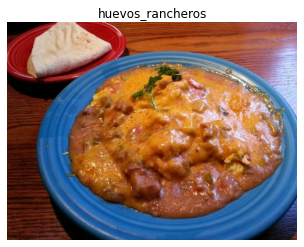

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

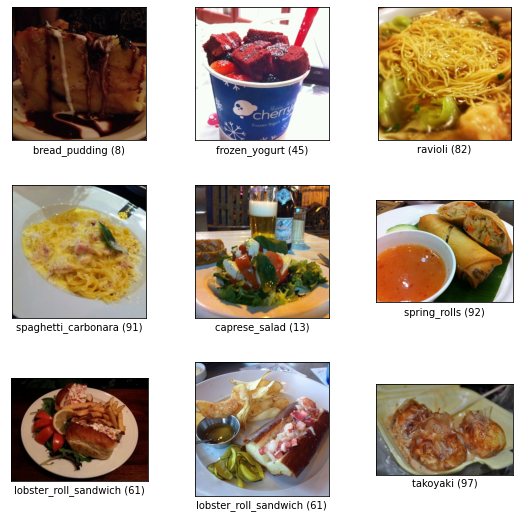

In [ ]:
# another way
fig = tfds.show_examples(train_data, ds_info)

## Create Preprocessing function for our data

In [ ]:
def preprocess_img(image, label, img_size = 224 ):
  """
  Convert image datatype to unint8 and reshape tp 224 or multiple of 8 (GPU preference)
  """
  image = tf.image.resize(image, [img_size, img_size])

  return tf.cast(image, dtype = tf.float32), label # return (image, label) tuple

In [ ]:
preprocessed_img = preprocess_img(image, class_names[label.numpy()])
preprocessed_img

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         ...,
         [157.23973 ,  91.24997 , 110.18368 ],
         [150.2857  ,  86.622444, 107.239784],
         [144.57637 ,  80.47435 , 103.6325  ]],
 
        [[  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         ...,
         [157.85226 ,  91.70941 , 105.097206],
         [164.45404 ,  97.72448 , 114.3112  ],
         [159.09677 ,  93.16319 , 110.545815]],
 
        [[  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         ...,
         [156.04575 ,  86.47431 ,  96.6886  ],
         [156.8827  ,  89.31127 , 100.66844 ],
         [151.5303  ,  83.95888 ,  97.173164]],
 
        ...,
 
        [[ 66.50514 ,  29.862257

### Batching and preparing datasets

In [ ]:
# Map preprocessing data function to train_data and parallelize
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)

#Shuffle train_data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Now same for test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Creating Modeling CallBacks

In [ ]:
# Tensorboard checkpoint

In [ ]:
# ModelCheckpoint
checkpoint_path = "model_checkpoints/cp.ckpt"
Model_Checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor = "val_acc",
                                                     save_best_only = True,
                                                     save_weights_only = True,
                                                     save_freq = "epoch",
                                                     verbose = 0)

In [ ]:
tf.__version__

'2.7.0'

## Setting up the mixed_precision

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

# in our case it wont do anything bcz we are using GPU K80 that doesn't have Compute capability 7.0

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Buidling Model

In [ ]:
# Building Model with base model as EfficientNetB0
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0( include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = IMG_SHAPE, name = "Input_layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D_layer")(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32, name ="Output_layer")(x)

model = tf.keras.Model(inputs, outputs)



16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile( loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 Output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [ ]:
for layers in model.layers:
  print(f"layers name: {layers.name}, layers dtype: {layers.dtype} layers dtype_policy {layers.dtype_policy}")

layers name: Input_layer, layers dtype: float32 layers dtype_policy <Policy "float32">
layers name: efficientnetb0, layers dtype: float32 layers dtype_policy <Policy "mixed_float16">
layers name: GlobalAveragePooling2D_layer, layers dtype: float32 layers dtype_policy <Policy "mixed_float16">
layers name: dense, layers dtype: float32 layers dtype_policy <Policy "mixed_float16">
layers name: Output_layer, layers dtype: float32 layers dtype_policy <Policy "float32">


In [ ]:
initial_epoch = 3
history = model.fit(train_data,
                    epochs = initial_epoch,
                    steps_per_epoch = (len(train_data)),
                    validation_data = test_data,
                    validation_steps = int(0.15 * len(test_data)),
                    callbacks = [
                                 create_tensorboard_callback(dir_name = "Food101 Vision",
                                                             experiment_name = "Model_0_FeatureExtraction"),
                                Model_Checkpoint
                    ])

Saving TensorBoard log files to: Food101 Vision/Model_0_FeatureExtraction/20220204-113639


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8245 - accuracy: 0.5573WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 291s 112ms/step - loss: 1.8245 - accuracy: 0.5573 - val_loss: 1.2327 - val_accuracy: 0.6801
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2935 - accuracy: 0.6656WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 247s 103ms/step - loss: 1.2935 - accuracy: 0.6656 - val_loss: 1.1162 - val_accuracy: 0.6984
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1427 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 262s 110ms/step - loss: 1.1426 - accuracy: 0.7031 - val_loss: 1.0916 - val_accuracy: 0.7076


In [ ]:
results_feature_extraction = model.evaluate(test_data)

790/790 [==============================] - 85s 107ms/step - loss: 1.0841 - accuracy: 0.7067


## Preparing our model's layers for fine-tuning

Goal: to beat the DeepFood paper's 77.4% top-1 accuracy on Food101 (2-3 days of training).

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 Output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [ ]:
# Checking the trainability of layers in our model
for layer in model.layers:
   print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
GlobalAveragePooling2D_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
Output_layer True float32 <Policy "float32">


As the base model trainability is False lets change it to True so that we can fine-tune the model

In [ ]:
for layer in model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
GlobalAveragePooling2D_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
Output_layer True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

### Creating Callbacks

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
              metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101food_fine_tune = model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                      model_checkpoint, # save only the best model during training
                                      early_stopping, # stop model after X epochs of no improvements
                                      reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220204-115901
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.7518

INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 1226s 503ms/step - loss: 0.9247 - accuracy: 0.7518 - val_loss: 0.8004 - val_accuracy: 0.7752 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.8385

INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 1174s 495ms/step - loss: 0.5804 - accuracy: 0.8385 - val_loss: 0.7969 - val_accuracy: 0.7805 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 1120s 472ms/step - loss: 0.3334 - accuracy: 0.9053 - val_loss: 0.8502 - val_accuracy: 0.7855 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9485
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 1109s 468ms/step - loss: 0.1733 - accuracy: 0.9485 - val_loss: 1.0025 - val_accuracy: 0.7767 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 1113s 469ms/step - loss: 0.0359 - accuracy: 0.9916 - val_loss: 1.0586 - val_accuracy: 0.8056 - lr: 2.0000e-05


In [ ]:
# Evaluate mixed precision trained loaded model on test data
results_model_fine_tuned = model.evaluate(test_data) 
results_model_fine_tuned

790/790 [==============================] - 81s 103ms/step - loss: 1.0510 - accuracy: 0.7996


[1.0510029792785645, 0.7995643615722656]

##Prediction on Custom Images

In [ ]:
!wget https://github.com/ozzmanmuhammad/FoodVision/blob/main/Images/custom_food_images.zip

--2022-02-04 13:47:56--  https://github.com/ozzmanmuhammad/FoodVision/blob/main/Images/custom_food_images.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘custom_food_images.zip’

custom_food_images.     [ <=>                ] 165.36K  --.-KB/s    in 0.08s   

2022-02-04 13:47:56 (2.13 MB/s) - ‘custom_food_images.zip’ saved [169326]



In [ ]:
from helper_functions import unzip_data, load_and_prep_image

In [ ]:
!unzip "/content/custom_food_images.zip"

In [ ]:
import os
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/icecream(1).jpg',
 'custom_food_images/steak.jpg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/Samosa.jpg',
 'custom_food_images/icecream.jpg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza.jpg',
 'custom_food_images/hamburger (1).jpg',
 'custom_food_images/chicken_wings.jpeg']

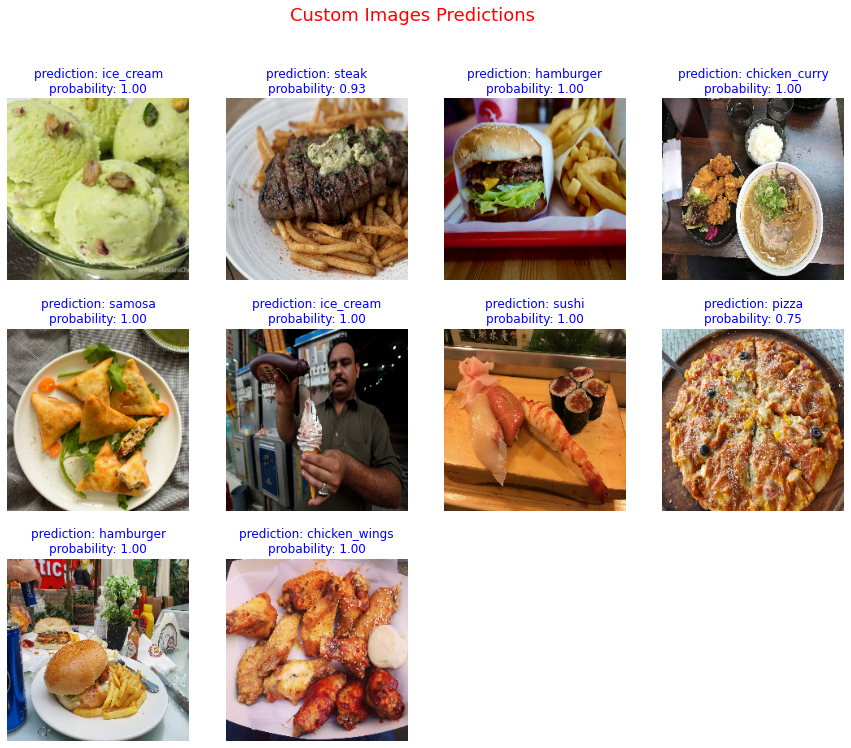

In [ ]:
# Make predictions on custom food images

plt.figure(figsize=(15, 12))
# plt.subplots_adjust(hspace=0.1)
plt.suptitle("Custom Images Predictions", fontsize=18, c = "r")

for img_number, img in enumerate(custom_food_images):

  ax = plt.subplot(3, 4, img_number + 1)

  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  # plt.figtext(f"prediction: {pred_class}\n", c = "red")
  plt.title(f"prediction: {pred_class}\nprobability: {pred_prob.max():.2f}", c = "blue")
  plt.axis(False)
plt.savefig("Predictions_Custom_Images.jpg")